# Model Evaluation

In [3]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import os

class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        
        self.hidden_size = 256
        self.num_layers = 3
        self.lstm = nn.LSTM(input_size=40, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 1)  # Ajustado para LSTM unidirecional

        #self.linear1 = nn.Linear(40, 30)
        #self.relu1 = nn.ReLU()
        #self.linear2 = nn.Linear(30, 20)
        #self.relu2 = nn.ReLU()
        #self.linear3 = nn.Linear(20, 10)
        #self.relu3 = nn.ReLU()
        #self.linear4 = nn.Linear(10, 1)
        #self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Garantir que a entrada tenha 3 dimensões
        x, _ = self.lstm(x)  # x: (batch_size, seq_length, hidden_size)
        x = self.linear(x)  # Apenas a última saída da sequência

        #x = self.linear1(x)
        #x = self.relu1(x)
        #x = self.linear2(x)
        #x = self.relu2(x)
        #x = self.linear3(x)
        #x = self.relu3(x)
        #x = self.linear4(x)
        #x = self.sigmoid(x)

        return x

model_path = "models/model_best_rmse.pt"
data_path = "Server_1_Training_Sets/datasets/cpu_usage_14.xlsx"

# Verificar dispositivo disponível (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Carregar o modelo treinado
model = torch.load(model_path)
model = model.to(device)  # Mover modelo para o dispositivo apropriado
model.eval()  # Configura o modelo para modo de avaliação

# Carregar os dados do dia 14
df = pd.read_excel(data_path)
X_test = df.iloc[:, :-1].values  # Todas as colunas, exceto a última (entradas)
y_test = df.iloc[:, -1].values   # Apenas a última coluna (saídas reais)

# Preparar os tensores e movê-los para o dispositivo
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Fazer previsões
# Preenchimento inicial com valores reais
predictions = []

with torch.no_grad():
    y_pred = model(X_test_tensor.unsqueeze(1))  # Adiciona dimensão para compatibilidade com o modelo

# Converter tensores para numpy (movendo para CPU antes de converter)
y_pred = y_pred.squeeze().cpu().numpy()
y_test = y_test_tensor.cpu().numpy()

for t in range(len(y_pred)):
    if t < 400:
        # Usar valores reais para as primeiras iterações
        predictions.append(y_test[t])
    else:
        # Usar previsões do modelo
        predictions.append(y_pred[t])

# Calcular o RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))

# Imprimir os resultados
print(f"RMSE no Conjunto de Teste (Dia 14): {rmse:.6f}")
print(f"Total de Amostras de Teste: {len(X_test)}")

# Salvar resultados em um arquivo
with open("models/performance.txt", "a") as f:
    f.write(f"\nModel Test RMSE (Dia 14): {rmse:.6f}")

Using device: cuda


/tmp/ipykernel_212466/224255542.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


RMSE no Conjunto de Teste (Dia 14): 0.031098
Total de Amostras de Teste: 9560


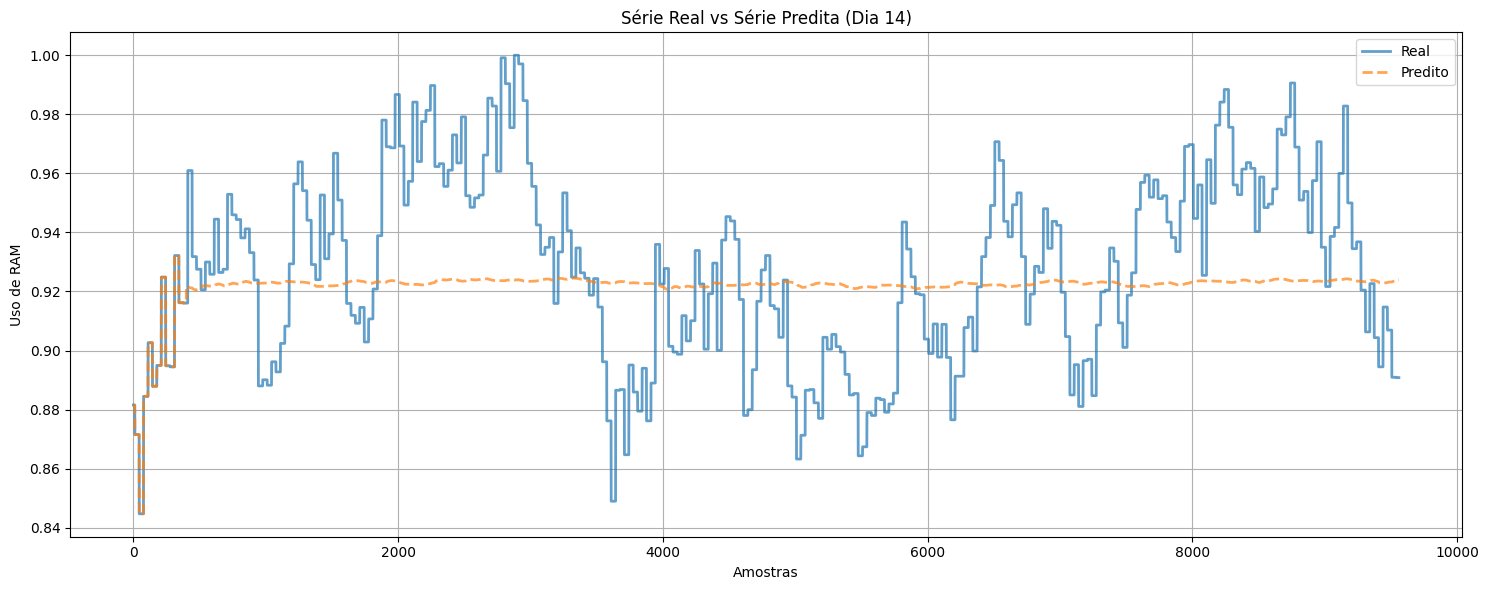

In [4]:
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

# Plotar a série real e a série predita
plt.figure(figsize=(15, 6))
plt.plot(y_test[:9560], label="Real", linewidth=2, alpha=0.7)
plt.plot(predictions[:9560], label="Predito", linewidth=2, alpha=0.7, linestyle="--")
plt.title("Série Real vs Série Predita (Dia 14)")
plt.xlabel("Amostras")
plt.ylabel("Uso de RAM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/prediction_vs_real_day14.png", dpi=300)  # Salvar o gráfico
plt.show()

In [20]:
y_pred

array([0.04000056, 0.04000044, 0.0400005 , ..., 0.04026492, 0.04026506,
       0.04026518], dtype=float32)

In [21]:
y_test

array([0.03943832, 0.03944139, 0.03943547, ..., 0.0397261 , 0.0397312 ,
       0.03972419], dtype=float32)